In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

base_path = Path("/content/drive/MyDrive/penelitian/PI")
dataset_path = base_path / "dataset"
print("📁 Dataset:", dataset_path)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
CLASS_NAMES = sorted(os.listdir(dataset_path))
print("🔖 Kelas:", CLASS_NAMES)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Prefetch agar training lebih cepat
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalisasi
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Transfer Learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Bekukan layer awal

# Tambahkan classifier head
global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
drop = tf.keras.layers.Dropout(0.3)(global_avg)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(drop)

model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

# Fine Tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Bekukan sebagian
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

# Ekstraksi Fitur
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=global_avg)
feature_extractor.trainable = False

def extract_features(dataset):
    features = []
    labels = []
    for imgs, lbls in dataset:
        feats = feature_extractor(imgs)
        features.append(feats.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

X_train, y_train = extract_features(train_ds)
X_val, y_val = extract_features(val_ds)

print("🔍 Bentuk Fitur:", X_train.shape)
print("🔍 Bentuk Label:", y_train.shape)

# SVM Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

svm_clf = svm.SVC(kernel='rbf', C=2, gamma='scale', probability=True)
svm_clf.fit(X_train_scaled, y_train)

# Validasi
y_pred = svm_clf.predict(X_val_scaled)
print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM + MobileNetV2 Features)')
plt.show()

# Simpan
model_dir = base_path / "models"
os.makedirs(model_dir, exist_ok=True)
model.save(model_dir / "mobilenetv2_emotion_model.h5")
print(f"✅ Model disimpan di: {model_dir}")

Mounted at /content/drive
📁 Dataset: /content/drive/MyDrive/penelitian/PI/dataset
🔖 Kelas: ['Angry', 'Fear', 'Happy', 'Sad']
Found 1285 files belonging to 4 classes.
Using 1028 files for training.
Found 1285 files belonging to 4 classes.
Using 257 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.2701 - loss: 1.8177 - val_accuracy: 0.2646 - val_loss: 1.6047
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2796 - loss: 1.7068 - val_accuracy: 0.3152 - val_loss: 1.5513
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3209 - loss: 1.6149 - val_accuracy: 0.3346 - val_loss: 1.5041
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3226 - loss: 1.5582 - val_accuracy: 0.3580 - val_loss: 1.4535
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3492 - loss: 1.4821 - val_accuracy: 0.3696 - val_loss: 1.4171
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step 

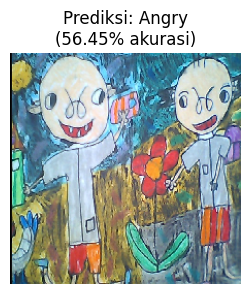

🖼️ gambar-1.jpg → Emosi: Angry (56.45%)


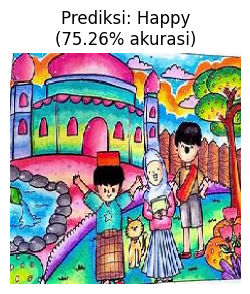

🖼️ gambar-2.jpeg → Emosi: Happy (75.26%)


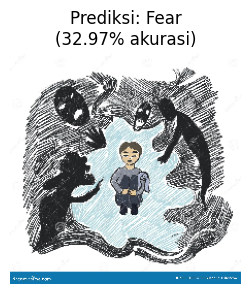

🖼️ gambar-3.webp → Emosi: Fear (32.97%)


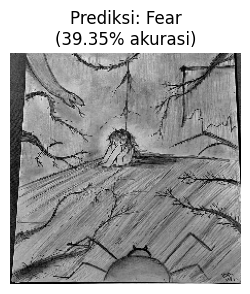

🖼️ gambar-4.jpg → Emosi: Fear (39.35%)


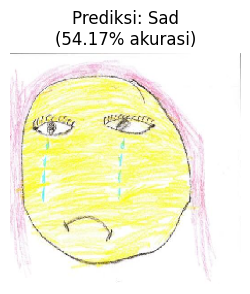

🖼️ gambar-14.jpg → Emosi: Sad (54.17%)


In [ ]:
from tensorflow.keras.preprocessing import image

# Tes Prediksi Dari Folder Testing
testing_path = base_path / "testing"
test_images = ["gambar-1.jpg", "gambar-2.jpeg", "gambar-3.webp", "gambar-4.jpg", "gambar-14.jpg"]

def predict_and_show(img_name):
    img_path = testing_path / img_name
    if not img_path.exists():
        print(f"⚠️ File {img_name} tidak ditemukan di {testing_path}")
        return

    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Ekstraksi fitur dan normalisasi
    features = feature_extractor(img_array)
    scaled = scaler.transform(features)
    pred_class = svm_clf.predict(scaled)[0]
    pred_prob = svm_clf.predict_proba(scaled)[0]

    # Tampilkan hasil
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediksi: {CLASS_NAMES[pred_class]}\n({pred_prob[pred_class]*100:.2f}% akurasi)")
    plt.show()

    print(f"🖼️ {img_name} → Emosi: {CLASS_NAMES[pred_class]} "
          f"({pred_prob[pred_class]*100:.2f}%)")

# Jalankan prediksi untuk gambar-1.jpg dan gambar-4.jpg
for name in test_images:
    predict_and_show(name)
